# CV Week: Итоговое задание

На лекции и семинаре мы разбирали как дистиллировать многошаговую диффузионную модель в малошагового студента, и тем самым будет работать на порядок быстрее учителя.

Один из подходов, который мы разбирали *Consistency Distillation*. В этом задании, мы закрепим материал, который был на лекции и семинаре и реализуем этот фреймворк, затрагивая различные нюансы.

В этом задании мы будем дистиллировать модель *Stable Diffusion 1.5 (SD1.5)* для генерации картинок по текстовому описанию.

Вам предстоит выполнить 8 небольших заданий, которые приведут нас к неплохой модели для генерации картинок за 4 шага, работая в органиченных условиях колаба.

In [1]:
# # torch 2.4.1+cu124
# !pip install diffusers==0.30.3, peft==0.8.2 huggingface_hub==0.23.4

## Теормин

---
##### Диффузионные модели

Задан прямой диффузионный процесс, который переводит чистые картинки в шум с помощью распределения $q(\mathbf{x}_t | \mathbf{x}_0)= {N}(\mathbf{x}_t | \alpha_t \mathbf{x}_0, \sigma^2_t I)$

Таким образом, мы можем получаться зашумленные картинки по следующей формуле: $\mathbf{x}_t = \alpha_t \mathbf{x}_0 + \sigma_t \epsilon$, где $\epsilon{\sim} {N}(0, I)$ **(1)**

$\alpha_t, \sigma_t$ задают процесс зашумления. Здесь мы будем иметь дело с *variance preserving (VP)* процессом, т. е., $\alpha^2_t = 1 - \sigma^2_t$.

Диффузионная модель (ДМ) пытается решить обратную задачу: из шума порождать новые картинки.
Важно, что диффузионный процесс можно описать следующим обыкновенным дифференциальным уравнением (ОДУ):

 $dx = \left[ f(\mathbf{x}, t) - \frac{1}{2} \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}) \right] dt$, **(2)**

где $f(\mathbf{x}, t)$ известен из заданного процесса зашумления, а $\nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)$ (*скор функцию*) оцениваем с помощью нейросети: $s_\theta(\mathbf{x}_t, t) \approx \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)$. Таким образом, имея оценку на $\nabla_{\mathbf{x}_t} \log p_t(\mathbf{x})$, мы можем решить это ОДУ, стартуя со случайного шума, и получить картинку.


**SD1.5** использует *$\epsilon$-параметризацию*, т.е., UNet пытается предсказать шум, который мы добавили на картинку по формуле **(1)**. Оценку скор функции можно получить, пользуясь результатом, вытекающим из формулы Твидди: $s_\theta(\mathbf{x}_t, t) = - \frac{\epsilon_\theta(\mathbf{x}_t, t)} { \sigma_t}$

Чтобы решить ОДУ **(2)**, нам нужно воспользоваться каким-то численным методом (солвером). В этом задании мы будем работать с не самым эффектным, но самым популярным солвером: **DDIM**, который является адаптированным методом Эйлера под диффузионный ОДУ.

Для VP процесса переход с помощью DDIM с шага $t$ на $s$ можно сделать следующим образом:

$
x_s = DDIM(\mathbf{x}_t, t, s) = \alpha_s \cdot \left(\frac{\mathbf{x}_t - \sigma_t \epsilon_\theta}{\alpha_t} \right) + \sigma_s \epsilon_\theta
$

Этот переход можно интерпретировать так: получаем оценку на чистую картинку $\mathbf{x}_0$ на шаге $t$, используя $\frac{\mathbf{x}_t - \sigma_t \epsilon_\theta}{\alpha_t}$, а потом снова зашумляем эту оценку на шаг $s$ по формуле **(1)**, но только используем не случайный шум, а шум предсказанный моделью $\epsilon_\theta$.

*Используя DDIM для SD1.5, можем получать хорошие картинки за 50 шагов.*

**SD1.5** - латентная ДМ, т.е. модель работает не в пиксельном пространстве, а в латентном пространстве **VAE**. Таким образом SD1.5 состоит из следующих компонент:

1) **VAE** - переводит $3{\times}512{\times}512$ картинки в латенты $4{\times}64{\times}64$ и может декодировать их обратно в картинки.
2) **Текстовый энкодер** - извлекает текстовые признаки из промпта. Эти признаки будут подаваться в диффузионную модель, чтобы дать модели информацию, что именно хотим сгенерировать
3) **Диффузионная модель** - UNet, работающий на "латентных картинках" $4{\times}64{\times}64$.

---
#### Консистенси модели

##### Общая идея

Главная цель дистилляции диффузии - уменьшить количество шагов ДМ, при этом сохранив высокое качество картинок.

**Консистенси модели (Consistency Models | CM)** - класс моделей, где мы хотим выучить "консистенси функцию" $f_\theta(\mathbf{x}_t)$ - с любой точки $\mathbf{x}_{t}$ траектории диффузионного ОДУ **(2)** сразу предсказывать $\mathbf{x}_{0}$ (чистые данные) за один шаг.
Если мы идеально выучим консистенси функцию, то сможем шагать из чистого шума сразу в картинку, что супер эффективно в отличии от генерации ДМ.

Отметим, что консистенси модель можно учить как независимую генеративную модель, без предобученной ДМ, и в *задании 3* вам предстоит подумать, как это можно сделать.

<br>

<div>

<img src="https://i.postimg.cc/prgMVw6C/cd-idea.jpg" width="600"/>
</div>


**Консистенси дистилляция (Consistency Distillation | CD)** - подход, когда для обучения CM, мы используем предобученную ДМ. ДМ нам дает качественную инициализацию модели и уже обученную скор функцию, что сильно упрощает сходимость консистенси моделей.


### Обучение CM

<div>
<img src="https://i.postimg.cc/2jnsnKMs/cd-training.jpg" width="600"/>
</div>


Главная принцип обучения консистенси моделей заключается в попытке удовлетворить *self-consistency* св-ву: выход CM на двух соседних точках траектории $\mathbf{x}_{t}$ и $\mathbf{x}_{t-1}$ должен совпадать по какой-то мере близости, например L2 расстояние: $\lVert f_\theta(\mathbf{x}_{t-1}) - f_\theta(\mathbf{x}_{t}) \rVert^2_2$.

Заметим, что self-consistency св-во удовлетворить очень просто без какого-либо обучения, взяв, например $f_\theta(\mathbf{x}_{t}) \equiv 0$.

Поэтому, чтобы избежать вырожденных решений, нам необходимо выставить граничное условие (boundary condition), которое будет требовать, чтобы в самой левой точке траектории около 0, модель предсказывала картинку, которую получает на вход: $f_\theta(\mathbf{x}_{\epsilon}) = \mathbf{x}_{\epsilon}$.

**Практическое замечание:** Для обеих точек траектории мы применяем одну и ту же модель $f_\theta(\cdot)$. Но выход модели на шаге ${t-1}$ является "таргетом" для выхода модели на шаге $t$ и поэтому выполнение модели для шага $t-1$ выполняется в *torch.no_grad* режиме.

**Как получаться две соседние точки на траектории ОДУ?**

Берем случайную картинку $\mathbf{x}_0$ из датасета.

Точку $\mathbf{x}_t$ получаем с помощью прямого процесса зашумления: $\mathbf{x}_t = q(\mathbf{x}_t | \mathbf{x}_0)$

Чтобы получить соседнюю точку $\mathbf{x}_{t-1}$, нам нужно сделать шаг по траектории ОДУ, используя, например, DDIM солвер.

В консистенси дистилляции, мы делаем шаг предобученной ДМ: $\mathbf{x}_{t-1} = DDIM(\epsilon_\theta(\mathbf{x}_t, t), \mathbf{x}_t, t, t-1)$

**Важно:** на практике мы можем брать не соседние шаги $t$ и $t-1$, а с некоторым интервалом, например 20 шагов.
Размер интервала влияет на bias/variance trade-off в консистенси обучении: больше интервал между шагами - больше смещение, но меньше дисперсия, и наоборот.
Для простоты в этом задании мы зафиксируем интервал - 20 шагов, но во многих работах размер интервала динамически меняют по ходу обучения.

In [1]:
from tqdm.auto import tqdm

import csv
import os
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline, LCMScheduler, UNet2DConditionModel, DDIMScheduler

from peft import LoraConfig, get_peft_model, get_peft_model_state_dict

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
#---------------------
# Visualization utils
#---------------------

def visualize_images(images):
    assert len(images) == 4
    plt.figure(figsize=(12, 3))
    for i, image in enumerate(images):
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')

    plt.subplots_adjust(wspace=-0.01, hspace=-0.01)


#--------------
# Tensor utils
#--------------

def extract_into_tensor(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

#---------------
# Dataset utils
#---------------

class COCODataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, subset_name="train2014_5k", transform=None, max_cnt=None):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.extensions = (
            ".jpg",
            ".jpeg",
            ".png",
            ".ppm",
            ".bmp",
            ".pgm",
            ".tif",
            ".tiff",
            ".webp",
        )
        sample_dir = os.path.join(root_dir, subset_name)

        # Collect sample paths
        self.samples = sorted(
            [
                os.path.join(sample_dir, fname)
                for fname in os.listdir(sample_dir)
                if fname[-4:] in self.extensions
            ],
            key=lambda x: x.split("/")[-1].split(".")[0],
        )
        self.samples = (
            self.samples if max_cnt is None else self.samples[:max_cnt]
        )  # restrict num samples

        # Collect captions
        self.captions = {}
        with open(
            os.path.join(root_dir, f"{subset_name}.csv"), newline="\n"
        ) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=",")
            for i, row in enumerate(spamreader):
                if i == 0:
                    continue
                self.captions[row[1]] = row[2]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_path = self.samples[idx]
        sample = Image.open(sample_path).convert("RGB")

        if self.transform:
            sample = self.transform(sample)

        return {
            "image": sample,
            "text": self.captions[os.path.basename(sample_path)],
            "idxs": idx, }

# Модель учителя (SD1.5)

## Задание №1

Давайте для начала загрузим модель [StableDiffusion 1.5](https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5) и сгенерируем ей картинки за 50 шагов.

**Важно:** для экономии памяти, загружаем все компоненты модели в FP16. Не забываем положить модель на GPU.

In [3]:
pipe = StableDiffusionPipeline.from_pretrained("sd-legacy/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Проверяем, что все компоненты модели в FP16 и на cuda
assert pipe.unet.dtype == torch.float16 and pipe.unet.device.type == 'cuda'
assert pipe.vae.dtype == torch.float16 and pipe.vae.device.type == 'cuda'
assert pipe.text_encoder.dtype == torch.float16 and pipe.text_encoder.device.type == 'cuda'

# Заменяем дефолтный сэмплер на DDIM
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
pipe.scheduler.timesteps = pipe.scheduler.timesteps.cuda()
pipe.scheduler.alphas_cumprod = pipe.scheduler.alphas_cumprod.cuda()

# Отдельно извлечем модель учителя, которую потом будем дистиллировать
teacher_unet = pipe.unet

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Теперь сгенерируем картинки за 50 шагов. Вам нужно написать вызов pipe и передать в него промпт, число шагов генерации, генератор случайных чисел, гайденс скейл и указать, чтобы сгенерировалось 4 картинки на промпт.

In [4]:
# prompt = "A sad puppy with large eyes"
# guidance_scale = 7.5
# generator = torch.Generator('cuda').manual_seed(1)

# images = pipe([prompt], generator=generator, num_inference_steps=50, guidance_scale=guidance_scale, num_images_per_prompt=4).images

# visualize_images(images)

Давайте посмотрим, что выдаст модель за 4 шага.
Все то же самое, что и выше, просто поменяем число шагов.

In [5]:
# generator = torch.Generator('cuda').manual_seed(1)

# images = pipe([prompt], generator=generator, num_inference_steps=4, guidance_scale=guidance_scale, num_images_per_prompt=4).images

# visualize_images(images)

На 4 шагах картинки получаются размазанными. Давайте постараемся починить их.

##  Создаем датасет

Чтобы ДЗ было легко выполнимым на colab, мы будем учить консистенси модели на небольшой обучающей выборке из 5000 пар текст-картинка из COCO датасета.
Интересное свойство консистенси моделей - они могут сходиться до адекватного качества за несколько сотен шагов. Качество все еще будет не идеальным, но фазовый переход уже должен быть заметен.

Данные можно загрузить с помощью команд в ячейке ниже. В локальной текущей директории ./ должны появиться:
* Папка train2014_5k с 5000 картинками
* Файл train2014_5k.csv с 5000 промптами

Данные парсятся корректным образом в уже реализованном классе COCODataset.

In [6]:
# !wget https://storage.yandexcloud.net/yandex-research/train2014_5k.tar.gz
# !tar -xzf train2014_5k.tar.gz

**Замечание:** для более быстрого дебаггинга можете взять, например, 2500 картинок и прогнать на всей выборке только в самом конце. 2500 картинок должно быть достаточно для понимания корректно ли реализованы функции.
Совсем для первичного дебаггинга можно взять еще меньше картинок.

In [7]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        lambda x: 2 * x - 1,
    ]
)
dataset = COCODataset(".",
    subset_name="train2014_5k",
    transform=transform,
    max_cnt=2500
)
assert len(dataset) == 2500

batch_size = 8 # Рекоммендуемы размер батча на Colab

train_dataloader = torch.utils.data.DataLoader(
    dataset=dataset, shuffle=True, batch_size=batch_size, drop_last=True
)

In [8]:
@torch.no_grad()
def prepare_batch(batch, pipe):
    """
    Предобработка батча картинок и текстовых промптов.
    Маппим картинки в латентное пространство VAE.
    Извлекаем эмбеды промптов с помощью текстового энкодера.

    Params:

    Return:
        latents: torch.Tensor([B, 4, 64, 64], dtype=torch.float16)
        prompt_embeds: torch.Tensor([B, 77, D], dtype=torch.float16)
    """

    # Токенизируем промпты
    text_inputs = pipe.tokenizer(
        batch['text'],
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    # Извлекаем эмбеды промптов с помощью текстового энкодера
    prompt_embeds = pipe.text_encoder(text_inputs.input_ids.cuda())[0]

    # Переводим картинки в латентное пространство VAE
    image = batch['image'].to("cuda", dtype=torch.float16)
    latents = pipe.vae.encode(image).latent_dist.sample()
    latents = latents * pipe.vae.config.scaling_factor
    return latents, prompt_embeds

### Подготовка моделей и оптимизатора

Для начала создаем обучаемую модель: UNet инициализируемый весами SD1.5.
Вам нужно воспользоваться классом UNet2DConditionModel и загрузить отдельно только UNet модель из SD1.5.

Отметим, что эта модель у нас будет храниться в полной точности FP32, потому что обучение параметров в FP16 может приводить к нестабильностям и низкому качеству.

In [9]:
unet = UNet2DConditionModel.from_pretrained("sd-legacy/stable-diffusion-v1-5", subfolder="unet")
unet = unet.to("cuda")
unet.train()

assert unet.dtype == torch.float32
assert unet.training

Для экономии памяти во время обучения будем учить не параметры самой модели, а добавим в нее обучаемые LoRA адаптеры с малым числом параметров.

LoRA представляет собой маленькую добавку к весам модели, где на одну матрицу весов $W \in \mathbb{R}^{m{\times}n} $ обучаются две низкоранговые матрицы $W_A \in \mathbb{R}^{k{\times}n}$ и $W_B \in \mathbb{R}^{k{\times}m}$, где $k$ - ранг матрицы сильно меньше $m$ и $n$.

Тем самым, новая обученная матрица весов может быть представлена как $\hat{W} = W + \Delta W = W + W^T_B W_A$.  
Во время инференса $\Delta W$ можно вмержить в $W$ и получить итоговую модель.
Также частая практика оставлять адаптеры как есть, чтобы была возможность для одной базовой модели учить несколько адаптеров под разные задачи и переключаться между ними по необходимости.

Если не мержить адаптеры, то вычисления для линейного слоя происходят как на картинке ниже.

<img src=https://miro.medium.com/v2/resize:fit:680/format:webp/0*2meitaJ7pdUusbb5.png width=300>

In [10]:
# Указываем к каким слоям модели мы будет добавлять адаптеры.
lora_modules = [
    "to_q", "to_k", "to_v", "to_out.0", "proj_in", "proj_out",
    "ff.net.0.proj", "ff.net.2", "conv1", "conv2", "conv_shortcut",
    "downsamplers.0.conv", "upsamplers.0.conv", "time_emb_proj"
]
lora_config = LoraConfig(
    r=64, # задает ранг у матриц A и B в LoRA.
    target_modules=lora_modules
)

# Создаем обертку исходной UNet модели с LoRA адаптерами, используя библиотеку PEFT
cm_unet = get_peft_model(unet, lora_config, adapter_name="ct")

# Включаем gradient checkpointing - важная техника для экономии памяти во время обучения
cm_unet.enable_gradient_checkpointing()

# Создаем оптимизатор
optimizer = torch.optim.AdamW(cm_unet.parameters(), lr=1e-4)

# Задаем лосс функцию для CM обжектива. В базовом варианте разумно взять L2
# По умолчанию, она уже выдает усредненное значение по всем размерностям
mse_loss = torch.nn.functional.mse_loss

## Задание №2 (0.5 балла, сдается в контесте)

####  Реализация шага DDIM

Шаг с помощью DDIM с $\mathbf{x}_t$ на $\mathbf{x}_s$ можно сделать следующим образом:

$
\mathbf{x}_s = DDIM(\epsilon_\theta, \mathbf{x}_t, t, s) = \alpha_s \cdot \left(\frac{\mathbf{x}_t - \sigma_t \epsilon_\theta}{\alpha_t} \right) + \sigma_s \epsilon_\theta
$

Вам нужно реализовать эту формулу в уже готовом шаблоне ниже.
Чтобы корректно выполнить задание, вам нужно задать $\alpha_t$ и $\sigma_t$ имея *DDIMScheduler*.
**Обратите внимание на аттрибут *scheduler.alphas_cumprod***, который задает $\bar\alpha_{t} = \prod^t_{i=1} (1-\beta_i)$ в классической DDPM формулировке: [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239).

In [11]:
def ddim_solver_step(model_output, x_t, t, s, scheduler):
    """
    Шаг DDIM солвера для VP процесса зашумления и eps-prediction модели
    params:
        model_output: torch.Tensor[B, 4, 64, 64] - предсказание модели - шум eps
        x_t: torch.Tensor[B, 4, 64, 64] - сэмплы на шаге t
        t: torch.Tensor[B] - номер текущего шага
        s: torch.Tensor[B] - номер следующего шага
        scheduler: DDIMScheduler - расписание диффузионного процесса, чтобы получить alpha и sigma
    """
    alphas = torch.sqrt(scheduler.alphas_cumprod)
    sigmas = torch.sqrt(1- scheduler.alphas_cumprod)

    sigmas_s = extract_into_tensor(sigmas, s, x_t.shape)
    alphas_s = extract_into_tensor(alphas, s, x_t.shape)

    sigmas_t = extract_into_tensor(sigmas, t, x_t.shape)
    alphas_t = extract_into_tensor(alphas, t, x_t.shape)

    # Выставляем крайние значения alpha и sigma, чтобы выполнялись граничные условия
    alphas_s[s == 0] = 1.0
    sigmas_s[s == 0] = 0.0

    alphas_t[t == 0] = 1.0
    sigmas_t[t == 0] = 0.0

    x_0 = (x_t - sigmas_t*model_output) / alphas_t # x0 оценка на шаге t
    x_s = alphas_s*x_0+sigmas_s*model_output # Переход на шаг s
    return x_s

####  Реализация процесса зашумления (q sample)

Аналогично, нам нужен процесс зашумления $q(\mathbf{x}_t | \mathbf{x}_0)= {N}(\mathbf{x}_t | \alpha_t \mathbf{x}_0, \sigma^2_t I)$

$\mathbf{x}_t = \alpha_t \mathbf{x}_0 + \sigma_t \epsilon$, где $\epsilon{\sim} {N}(0, I)$

In [12]:
def q_sample(x, t, scheduler, noise=None):
    alphas = torch.sqrt(scheduler.alphas_cumprod)
    sigmas = torch.sqrt(1- scheduler.alphas_cumprod)

    if noise is None:
        noise = torch.randn_like(x)

    sigmas_t = extract_into_tensor(sigmas, t, x.shape)
    alphas_t = extract_into_tensor(alphas, t, x.shape)

    x_t = alphas_t*x+sigmas_t*noise
    return x_t

# Consistency Training

Обучение консистенси моделей без учителя называется Consistency Training (CT).
В таком случае CM можно рассматривать как отдельный вид генеративных моделей.
Давайте начнем именно с этого подхода и обучим нашу первую консистенси модель на базе SD1.5.

## Задание №3

#### Задание №3.1 (0.5 балла, сдается в контесте)

В консиcтенси дистилляции модель учителя используется для получения второй точки на траектории ODE.
Можем ли мы попробовать оценить соседнюю точку аналитически?

Вам предлагается вывести это самим, используя формулу DDIM шага выше и вспомнив, как мы оцениваем скор функции в denoising score matching-e:

$\epsilon_\theta(x_t, t) = - \sigma_t s_\theta(x_t, t)$

$s_\theta(x_t, t) \approx \nabla_{x_t} \log q(x_t) = \mathop{\mathbb{E}}_{\mathbf{x}\sim p_{data}}\left [ \nabla_{\mathbf{x}_t} \log q(\mathbf{x}_t | \mathbf{x}) \vert \mathbf{x}_t \right ] \approx \nabla_{\mathbf{x}_t} \log q(\mathbf{x}_t \vert \mathbf{x})$

---

< YOUR DERIVATION HERE >
    
$x_s = ?$

---
    
Если возникнут трудность, можно обратиться к оригинальной [статье](https://arxiv.org/pdf/2303.01469).


Теперь реализуем то, что у вас получилось в функции ниже.

In [13]:
def get_xs_from_xt_naive(
    x_0, x_t, t, s, # Не все эти аргументы могут быть вам нужны
    scheduler,
    noise=None,
    **kwargs
):
    """
    Получение точки x_s в CT режиме, т.е., аналитически.
    """
    
    if x_t is not None:

        alphas = torch.sqrt(scheduler.alphas_cumprod)
        sigmas = torch.sqrt(1- scheduler.alphas_cumprod)

        sigmas_t = extract_into_tensor(sigmas, t, x_t.shape)
        alphas_t = extract_into_tensor(alphas, t, x_t.shape)
        sigmas_s = extract_into_tensor(sigmas, s, x_t.shape)
        alphas_s = extract_into_tensor(alphas, s, x_t.shape)
        alphas_s[s == 0] = 1.0
        sigmas_s[s == 0] = 0.0
        alphas_t[t == 0] = 1.0
        sigmas_t[t == 0] = 0.0
        
        noise = (x_t - alphas_t * x_0) / sigmas_t
    
    #x_0 = (x_t - sigmas_t * noise) / alphas_t
    x_s = q_sample(x_0, s, scheduler, noise)
    return x_s

#### Задание №3.2

Ниже предстален шаблон функции, которая считает лосс для консистенси моделей.
Вам нужно правильно заполнить пропуски, чтобы получилась корректная функция.

In [14]:
def cm_loss_template(
    latents, prompt_embeds, # батч латентов и текстовых эмбедов
    unet, scheduler,

    # Функции, которые будем постепенно менять из задания к заданию
    loss_fn: callable,
    get_boundary_timesteps: callable,
    get_xs_from_xt: callable,

    num_timesteps=1000,
    step_size=20, # Указываем с каким интервалом берем шаги s и t.
):
    # Сэмплируем случайные шаги t для каждого элемента батча t ~ U[step_size-1, 999]
    assert num_timesteps == 1000
    num_intervals = num_timesteps // step_size

    index = torch.randint(1, num_intervals, (len(latents),), device=latents.device).long() # [1, num_intervals]
    t = step_size * index - 1
    s = torch.clamp(t - step_size, min=0)
    boundary_timesteps = get_boundary_timesteps(
        s, num_timesteps=num_timesteps
    )

    # Сэмплируем x_t
    noise = torch.randn_like(latents)
    x_t = q_sample(latents, t, scheduler, noise)
    # with <YOUR CODE HERE>: # для реализации mixed-precision обучения в задании №4
    with torch.amp.autocast("cuda", torch.float16):
        noise_pred = unet(x_t.float(), t,
            encoder_hidden_states=prompt_embeds.float(),
        ).sample

    # Получаем оценку в граничной точке для x_t
    boundary_pred = ddim_solver_step(noise_pred, x_t, t, boundary_timesteps, scheduler)

    # Получаем сэмпл x_s из x_t
    x_s = get_xs_from_xt(
        latents, x_t, t, s,
        scheduler,
        prompt_embeds=prompt_embeds,
        noise=noise,
    )

    # Предсказание "таргет моделью"
    with torch.no_grad(), torch.amp.autocast("cuda", torch.float16):
        target_noise_pred = unet(x_s, s, encoder_hidden_states=prompt_embeds).sample

    # Получаем оценку в граничной точке для x_s
    boundary_target = ddim_solver_step(target_noise_pred, x_s, s, boundary_timesteps, scheduler)
    loss = loss_fn(boundary_pred, boundary_target)
    return loss

In [15]:
import functools
def get_zero_boundary_timesteps(t, **kwargs):
    """
    Определяем шаги где будут срабатывать граничные условия.
    Для классических СM это t=0.
    """
    return torch.zeros_like(t)


ct_loss = functools.partial(
    cm_loss_template,

    loss_fn=mse_loss,
    get_boundary_timesteps=get_zero_boundary_timesteps,
    get_xs_from_xt=get_xs_from_xt_naive
)
assert cm_unet.active_adapter == 'ct'

## Задание №4

### Эффективное обучение
Данное задание рассчитано на успешное выполнение на colab с бесплатной Tesla T4 c 15GB VRAM.
Однако учить даже относительно небольшие T2I модели масштаба SD1.5 уже на коллабе в лоб проблематично.

Для этого нам нужно применить ряд инженерных техник, чтобы уместиться в данный бюджет и учиться за разумное время.

**Список техник**

1) Включить gradient checkpointing для обучемой модели
2) Добавить LoRA (Low Rank Adapters) адаптеры, чтобы учить не все веса, а только 10% добавочных весов
3) Использовать gradient accumulation, чтобы делать итерацию обучения по бОльшему батчу, чем влезает по памяти
4) Добавить mixed precision FP16/FP32 обучение модели для скорости. Обычно еще и память экономится, но в случае LoRA обучения + gradient checkpointing на память сильно влиять не должно, но зато станет быстрее.
5) Мульти-GPU обучение - распределение вычислений по нескольким GPU.  

1-2) Мы уже применили за вас выше

3-4) Предстоит реализовать вам самим в соотвествующей секции ниже

5 ) Недоступно, так как работаем на одной карточке

### Обучающий цикл

Вам дан код обучения модель в полной точности (FP32) c батчом 8.
К сожалению, на Tesla T4 мы не влезем по памяти.
Поэтому в ячейке ниже вам нужно модифицировать цикл, чтобы он работал в mixed precision FP16 и добавить gradient accumulation.

Про реализацию mixed-precision в pytorch можно перейти по ссылке: [Mixed-precision обучение](https://pytorch.org/docs/stable/notes/amp_examples.html#typical-mixed-precision-training)

**Обратите внимание**: вам еще нужно добавить одну строчку кода в *cm_loss_template* в соответствующем плейсхолдере.

**Замечание:** В начале обучения значения лосса должны быть в окрестности 0.0007-0.001. Ничего страшного, что лосс не падает, для CM это нормально. В конце обучения лосс может доходить до 0.005-0.01

In [16]:
def train_loop(model, pipe, train_dataloader, optimizer, loss_fn, num_grad_accum=1):
    torch.cuda.empty_cache()
    scaler = torch.cuda.amp.GradScaler()
    for i, batch in enumerate(tqdm(train_dataloader)):

        if (i + 1) % num_grad_accum == 0:
            optimizer.zero_grad(set_to_none=True)

        latents, prompt_embeds = prepare_batch(batch, pipe)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            loss = loss_fn(latents, prompt_embeds, model, pipe.scheduler)
            loss = loss / num_grad_accum
        # Обновляем параметры
        scaler.scale(loss).backward()
        if (i + 1) % num_grad_accum == 0:
            scaler.step(optimizer)
            scaler.update()
            # loss.backward()
            # optimizer.step()

        print(f"Loss: {loss.detach().item()}")

In [ ]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()
# torch.cuda.empty_cache()

In [19]:
num_grad_accum = 2 # обновляем параметры каждые 2 шага

train_loop(cm_unet, pipe, train_dataloader, optimizer, ct_loss, num_grad_accum)

  0%|          | 0/312 [00:00<?, ?it/s]

Loss: 0.0005566491163335741
Loss: 0.0005431733443401754
Loss: 0.0004341118910815567
Loss: 0.0007105483673512936
Loss: 0.0008834510226733983
Loss: 0.0004619073588401079
Loss: 0.0007945334073156118
Loss: 0.0005042373086325824
Loss: 0.00045250810217112303
Loss: 0.00047665214515291154
Loss: 0.0007669676560908556
Loss: 0.0005353973829187453
Loss: 0.0010145907290279865
Loss: 0.0009013191447593272
Loss: 0.0008833660394884646
Loss: 0.0007066828547976911
Loss: 0.0009088554070331156
Loss: 0.0005710588884539902
Loss: 0.0007421554764732718
Loss: 0.0008715782896615565
Loss: 0.0005983744631521404
Loss: 0.0003907154896296561
Loss: 0.0006188828847371042
Loss: 0.0005129510536789894
Loss: 0.0007444645743817091
Loss: 0.0006453247042372823
Loss: 0.0003474137920420617
Loss: 0.0012183034559711814
Loss: 0.0003996778395958245
Loss: 0.0005834060139022768
Loss: 0.000483882671687752
Loss: 0.0004670964553952217
Loss: 0.0006713680922985077
Loss: 0.0009068984072655439
Loss: 0.0012229466810822487
Loss: 0.00121645710

In [20]:
#torch.save(cm_unet.state_dict(), 'cm.pt')
print('Saved')

Saved


## Задание 5

### Генерация с помощью обученной консистенси модели

Настало время погенерировать картинки с помощью нашей модели.
Напомним, что мы не можем для консистенси моделей использовать DDIM и другие классические солверы для диффузии.
Нам нужен специальный сэмплер для CM, который схематично изображен на картинке ниже:

<div>
<img src="https://i.postimg.cc/66bWLvnh/cd-sampling.jpg" width="600"/>
</div>

Чуть более формально:

$x_{t_n} \sim {N}(0, I)$

$for\ t_i \in [t_n, ..., t_1]:$

* $\epsilon \leftarrow unet(x_{t_i})$

* $x_0 \leftarrow DDIM(\epsilon, x_{t_i}, t_i, 0)$

* $x_{t_{i-1}} \leftarrow q(x_{t_{i-1}} | x_0)$


**Classifier-free guidance (CFG)**

Также вам надо реализовать поддержку CFG в CM сэмплирование. Вспомним формулу:

$\epsilon_w = {\color{blue}{\epsilon_{uncond}}} + w \cdot (\epsilon_{cond} - \epsilon_{uncond})$, где $w \geq 1$

**Обратим внимание**, что режим "без гайденса" соотвествует $w = 1$, что немного контринтуитивно, но в большинстве реализаций будет встречаться именно такой вид этой формулы.

In [28]:
#torch.save(cm_unet.state_dict(), 'cm.pt')

In [17]:
cm_unet.load_state_dict(torch.load('cm.pt', weights_only=True))

<All keys matched successfully>

In [21]:
@torch.no_grad()
def consistency_sampling(
    pipe,
    prompt,
    num_inference_steps=4,
    generator=None,
    num_images_per_prompt=4,
    guidance_scale=1,
):
    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)

    device = pipe._execution_device

    # Extract embeddings from text prompts. Implement the pipe.encode_prompt call
    do_classifier_free_guidance = guidance_scale > 0
    prompt_embeds, null_prompt_embeds = pipe.encode_prompt(
        prompt,
        num_images_per_prompt=num_images_per_prompt,
        do_classifier_free_guidance=do_classifier_free_guidance,
        device=device
    )
    assert prompt_embeds.dtype == null_prompt_embeds.dtype == torch.float16

    # Configure scheduler parameters
    assert pipe.scheduler.config['timestep_spacing'] == 'trailing'
    pipe.scheduler.set_timesteps(num_inference_steps)

    latents = torch.randn(batch_size*num_images_per_prompt,
                          pipe.unet.in_channels,
                          pipe.unet.sample_size, 
                          pipe.unet.sample_size, 
                          generator=generator, 
                          device=device, 
                          dtype=torch.float16)
    #latents = torch.zeros(batch_size*num_images_per_prompt, 4, 64, 64, generator=generator, device=device, dtype=torch.float16)
    for i, t in enumerate(tqdm(pipe.scheduler.timesteps)):
        t = torch.tensor([t] * len(latents)).to(device)
        zero_t = torch.tensor([0] * len(latents)).to(device)

        cond_noise_pred = pipe.unet(latents, t, encoder_hidden_states=prompt_embeds).sample

        if do_classifier_free_guidance:
            uncond_noise_pred = pipe.unet(latents, t, encoder_hidden_states=null_prompt_embeds).sample
            noise_pred = uncond_noise_pred + guidance_scale * (cond_noise_pred - uncond_noise_pred)
        else:
            noise_pred = cond_noise_pred

        # Get x_0 estimate from x_t
        x_0 = ddim_solver_step(noise_pred, latents, t, zero_t, pipe.scheduler)

        if i + 1 < num_inference_steps:
            # Transition to the next step
            s = pipe.scheduler.timesteps[i + 1]
            s = torch.tensor([s] * len(latents)).to(device)

            latents = q_sample(x_0, s, pipe.scheduler)
        else:
            # Last step
            latents = x_0

        latents = latents.half()

    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
    do_denormalize = [True] * image.shape[0]
    image = pipe.image_processor.postprocess(image, output_type="pil", do_denormalize=do_denormalize)
    return image

Попробуем сгененировать что-то нашей моделью. Можно поиграться с разными сидами и гайденс скейлами.

Референс, что примерно должно получиться на этом этапе для guidance_scale=2. Как видите, картинки стали почетче, но пока все еще так себе.

![img](https://i.postimg.cc/2jctrptY/ct-images.png)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/peft/tuners/lora/model.py:269: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  return getattr(self.model, name)


  0%|          | 0/4 [00:00<?, ?it/s]

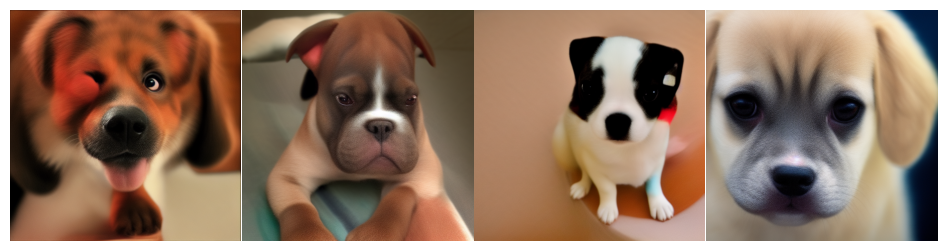

In [22]:
pipe.unet = cm_unet.eval().to(torch.float16)
assert cm_unet.active_adapter == 'ct'

generator = torch.Generator(device="cuda").manual_seed(1)
guidance_scale = 3
prompt = "A sad puppy with large eyes"
# Заменяем генерацию пайплайном на наше сэмплирование.
images = consistency_sampling(
    pipe,
    prompt,
    num_inference_steps=4,
    generator=generator,
    guidance_scale=guidance_scale,
    num_images_per_prompt=4
)

visualize_images(images)

# Consistency Distillation

## Задание №6


Теперь давайте попробуем перейти к постановке дистилляции, где шаг из $x_t$ в $x_s$ будет делаться не аналитически, а c помощью модели учителя.  

$\mathbf{x}_t = q(\mathbf{x}_t | \mathbf{x}_0)$

$\mathbf{x}_s = DDIM(\epsilon_\theta(\mathbf{x}_t, t), \mathbf{x}_t, t, s)$

**Замечание:**
В text-to-image генерации *classifier-free guidance (CFG)* играет очень важную роль для получения хорошего качества с помощью диффузии.
CFG меняет траектории ODE и раз нам он важен, то давайте и дистиллировать траектории с CFG.

Поэтому для получения точки $\mathbf{x}_{s}$ мы будем использовать шаг учителя с CFG. Это важное отличие от CT сеттинга - там мы не можем моделировать гайденс.

In [ ]:
unet = unet.to(torch.float32)
unet.train()
assert unet.dtype == torch.float32

# Добавляем новые LoRA адаптеры для CD модели
cm_unet.add_adapter("cd", lora_config)
cm_unet.set_adapter("cd")

# Пересоздаем оптимизатор
optimizer = torch.optim.AdamW(cm_unet.parameters(), lr=1e-4)

In [ ]:
@torch.no_grad()
def get_xs_from_xt_with_teacher(
    x_0, x_t, t, s, # Не все эти аргументы могут быть вам нужны
    scheduler,
    prompt_embeds,
    teacher_unet,
    guidance_scale,
    **kwargs
):
    # Делаем предсказание учителем в кондишион случае: подаем эмбеды текста
    cond_noise_pred = teacher_unet(x_t, t, encoder_hidden_states=prompt_embeds).sample

    # Для CFG нам нужно делать предсказания в unconditional случае.
    # Для T2I моделей, мы будем это моделировать предсказаниями для пустого промпта ""
    # Извлечем эмбеды из пустого промпта и размножить их до размера батча
    uncond_input_ids = pipe.tokenizer(
        [""], return_tensors="pt", padding="max_length", max_length=77
    ).input_ids.to("cuda")

    uncond_prompt_embeds = pipe.text_encoder(uncond_input_ids)[0].expand(
        *prompt_embeds.shape
    )

    # Затем прогоняем модель для пустых промптов
    uncond_noise_pred = teacher_unet(x_t, t, encoder_hidden_states=uncond_prompt_embeds).sample

    # Применяем CFG формулу и получаем итоговый предикт учителя
    noise_pred = uncond_noise_pred + guidance_scale * (cond_noise_pred - uncond_noise_pred)

    # Получаем x_s из x_t
    x_s = ddim_solver_step(noise_pred, x_t, t, s, scheduler)
    return x_s


# Сразу зададим внутрь модель учителя и guidance_scale
get_xs_from_xt_with_teacher = functools.partial(
    get_xs_from_xt_with_teacher,
    teacher_unet=teacher_unet,
    guidance_scale=7.5
)

Еще, как показано в работе [Improved Techniques for Training Consistency Models](https://arxiv.org/pdf/2310.14189).
L2 лосс не самый оптимальный выбор для консистенси моделей.
Давайте в CD обучении также заменим MSE лосс на pseudo-huber лосс из статьи.

In [ ]:
def pseudo_huber_loss(
    x: torch.Tensor,
    y: torch.Tensor,
    c=0.001
):
    diff = x - y

    squared_norm = torch.norm(diff, p=2) ** 2

    loss = torch.sqrt(squared_norm + c**2) - c
    return loss

In [ ]:
cd_loss = functools.partial(
    cm_loss_template,

    loss_fn=pseudo_huber_loss,
    get_boundary_timesteps=get_zero_boundary_timesteps,
    get_xs_from_xt=get_xs_from_xt_with_teacher
)

assert cm_unet.active_adapter == 'cd'

**Теперь обучим модель в CD режиме**

In [ ]:
num_grad_accum = 2 # обновляем параметры каждые 2 шага

train_loop(cm_unet, pipe, train_dataloader, optimizer, cd_loss, num_grad_accum)

### Снова сэмплируем

Обратим внимание, что тут мы сэмпилруем без гайденса, потому что мы его уже частично прокинули в модель, когда делали шаг учителя с CFG.

Снова для референса приводим картинки на этом этапе:

![img](https://i.postimg.cc/mgrsxVfW/download-1.png)

**Ваши картинки не обязаны совпадать: у вас могут быть немного менее/более качественные. Небольшая разница по качеству на оценку не влиет.**

In [ ]:
# Подставляем нашу новую обученную модель в пайплайн
pipe.unet = cm_unet.eval().to(torch.float16)
assert cm_unet.active_adapter == 'cd'

generator = torch.Generator(device="cuda").manual_seed(0)
guidance_scale = 0

images = <YOUR CODE HERE>

visualize_images(images)

#### Давайте посмотрим на картинки для других промптов


In [ ]:
validation_prompts = [
    "A sad puppy with large eyes",
    "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
    "A photo of beautiful mountain with realistic sunset and blue lake, highly detailed, masterpiece",
    "A girl with pale blue hair and a cami tank top",
    "A lighthouse in a giant wave, origami style",
    "belle epoque, christmas, red house in the forest, photo realistic, 8k",
    "A small cactus with a happy face in the Sahara desert",
    "Green commercial building with refrigerator and refrigeration units outside",
]

for prompt in validation_prompts:
    generator = torch.Generator(device="cuda").manual_seed(0)

    images = <YOUR CODE HERE>

    visualize_images(images)

# Multi-boundary Сonsistency Distillation
<div>
<img src=https://i.postimg.cc/tTzCv476/multi-cd.jpg width=600>
<div>

   В конце мы рассмотрим недавнюю модификацию CD, *Multi-boundary CD*, где интегрируем не всю траекторию сразу и потом сэмплируем с возвращением назад, а разбиваем траектории на $K$ отрезков и применяет CD внутри каждого отрезка независимо. Например, на картинке выше у нас два отрезка: зеленым и красным выделены две граничные точки.
Для классического CD, рассмотренного ранее, у нас только одна граничная точка в $t = 0$
    
**Обратим внимание**, что сэмплирование становится детерминистичным и можно снова использовать DDIM солвер, где число шагов равно числу интервалов $K$, на которые мы разбили траектории во время обучения.

Этот метод гораздо лучше работает чем обычный CD, потому что решать задачу CD на отрезках, а не на всей траектории, гораздо проще. В текущем задании мы разобьем траекторию на $K=4$ отрезка.

Подробнее почитать можно в этой [статье](https://arxiv.org/pdf/2403.06807).

## Задание №7 (0.25 балла, сдается в контесте)

Ниже реализуйте функцию, которая для $K=4$ отрезков будет сопоставлять таймстепам соответствующие граничные точки.

Например, для $K=2$ отрезков граничные точки будут: [0, 499]

$0 \leq t < 499$ -> граничная точка - $0$

$499 \leq t < 999$ -> граничная точка - $499$

**Замечание:** помним, что интервал между $t$ и $s$ - 20 шагов.


In [ ]:
def get_multi_boundary_timesteps(
    timesteps,
    num_boundaries=4,
    num_timesteps=1000,
):
    """
    Для батча таймстепов определяем соответствующие граничные точки.
    params:
        timesteps: torch.Tensor(batch_size, device='cuda')
    returns:
        boundary_timesteps: torch.Tensor(batch_size, device='cuda')
    """
    # Здесь важно повыводить timesteps и boundary_timesteps перед обучением,
    # чтобы не перелетать граничные точки и при этом иногда попадать в них.

    <YOUR CODE HERE>
    return boundary_timesteps

In [ ]:
multi_cd_loss = functools.partial(
    cm_loss_template,

    loss_fn=pseudo_huber_loss,
    get_boundary_timesteps=get_multi_boundary_timesteps,
    get_xs_from_xt=get_xs_from_xt_with_teacher
)
assert cm_unet.active_adapter == 'multi-cd'

**Теперь обучим  Multi-boundary CD модель**

In [ ]:
num_grad_accum = 2 # обновляем параметры каждые 2 шага

train_loop(cm_unet, pipe, train_dataloader, optimizer, multi_cd_loss, num_grad_accum)

### И в последний раз сэмплируем

**Важно:** теперь у нас появляется возможно сэмплировать детерминистично с помощью оригинального солвера DDIM за 4 шага. Так что возвращаем сэмплирование исходным pipe-ом.

Ниже прикрепляем референс и напомним, что у вас картинки могут отличаться и быть чуть хуже/лучше.
![img](https://i.postimg.cc/gjYzQ0n2/download-2.png)

In [ ]:
pipe.unet = cm_unet.eval().to(torch.float16)
assert cm_unet.active_adapter == 'multi-cd'

guidance_scale = 1

for prompt in validation_prompts:
    generator = torch.Generator(device="cuda").manual_seed(1)

    images = <YOUR CODE HERE>

    visualize_images(images)

## Задание №8

Все, что осталось сделать - это загрузить ваши обученные модельки на huggingface_hub.
Это очень популярный и удобный способ для хранения моделей, которые легко можно загружать и подставлять в модель.
Другими словами GitHub для моделей и датасетов.

1) Создайте аккаунт на [huggingface.co](huggingface.co)

2) Получите свой HF токен, который можно получить здесь: https://huggingface.co/settings/tokens

3) Создайте репозиторий для ваших моделями https://huggingface.co/new

**Важно: перед отправкой нотбука на проверку, не забудьте удалить свой HF токен!**

In [ ]:
cm_unet.push_to_hub(
    <YOUR REPO NAME HERE>, # "<username>/<repo-name>"
    token=<YOUR HF TOKEN HERE>
)

Пример, как должен выглядеть результат выполнения команды: https://huggingface.co/dbaranchuk/cv-week-final-task-example

Давайте проверим, что загрузка модели корректно работает.

In [ ]:
from peft import PeftModel

loaded_cm_unet = PeftModel.from_pretrained(
    unet,
    <YOUR REPO NAME HERE>,
    token=<YOUR HF TOKEN HERE>,
    subfolder='multi-cd',
    adapter_name="multi-cd",
)

In [ ]:
pipe.unet = loaded_cm_unet.eval().to(torch.float16)
assert loaded_cm_unet.active_adapter == 'multi-cd'

guidance_scale = 1

for prompt in validation_prompts:
    generator = torch.Generator(device="cuda").manual_seed(1)

    images = <YOUR CODE HERE>
кст
    visualize_images(images)

**На этом все! Ура!**

<div>
<img src="https://i.postimg.cc/jq8F6Yvk/photo-2024-11-27-21-57-13.jpg" width=400>
<div>

### P.S. Некоторые примеры плохих генераций, которые могут возникать при выполнении задания

#### Неправильный сэмплинг

![img](https://i.postimg.cc/TYM2vR4M/photo-2024-11-29-02-14-50.jpg)

![img](https://i.postimg.cc/XYnVXsWs/photo-2024-11-29-02-16-00.jpg)

#### Ошибки в обучении

![img](https://i.postimg.cc/XJfHZk4g/photo-2024-11-29-02-35-05.jpg)
![img](https://i.postimg.cc/RF5pVD5F/photo-2024-11-29-02-24-38.jpg)

#### Необученная модель

![img](https://i.postimg.cc/8zwTvLPN/photo-2024-11-29-01-58-36.jpg)
